# Analyzing neuropil signals in all the mice
* 10/18/23 setup based on `Neuropil_analysis_single_exp.ipynb`
* adding dfof caluclation

In [3]:
import sys, os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from os.path import join
import pandas as pd
import scipy.signal as signal
import numpy as np

sys.path.append("/home/gergely/code/sleep/base/")

from suite2p_class import Suite2p
from mouse_class import Mouse
from eeg_class import eegData
from behavior_class import behaviorData
import dfof


def freq_calc(data: pd.Series, fs: int = 10):
    """data: npil_eeg data"""
    frequencies, psd = signal.welch(data, fs=fs, detrend="linear")
    return frequencies, psd

In [4]:
sima_folders = [
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima",
]

gcs = [
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima",
]

mcs = [
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima",
]

In [6]:
# runs for about 6 minutes.

results = {}

for sima_folder in sima_folders:
    print(sima_folder)
    sima_dict = {}

    # Load eeg data
    file_name = join(sima_folder, "eeg", "velo_eeg.csv")
    eeg_velo = eegData.load_processed_velocity_eeg(file_name=file_name)
    eeg_velo["mobile_immobile"] = behaviorData.define_immobility(
        eeg_velo["filtered velo"]
    )
    df = eegData.brain_state_filter(
        velo_eeg_df=eeg_velo,
        states=["awake_mobile", "awake_immobile", "NREM", "REM", "other"],
    )

    s2p_folder = join(sima_folder, "suite2p")
    s2p_data = Suite2p(s2p_folder=s2p_folder)
    s2p_calc_dfof = dfof.Suite2pDFOF(window=1800)
    jia_calc_dfof = dfof.JiaDFOF(slow_trend_window=1800)

    # Calculate dfof
    cells = s2p_data.cells()
    npil = s2p_data.npil()
    cell_dfof = s2p_calc_dfof.calculate(signal=cells, npil=npil)
    npil_dfof = jia_calc_dfof.calculate(signal=npil)

    # Calculate mean dfof
    mean_cellF = cell_dfof.mean(axis=0)
    mean_npilF = npil_dfof.mean(axis=0)

    # Calculate freq and psd of cells
    awake_cell = pd.Series(mean_cellF[df["awake_immobile"]].values)
    awake_cell_freq, awake_cell_psd = freq_calc(awake_cell)
    sima_dict["awake_cell"] = {
        "freq": awake_cell_freq,
        "psd": awake_cell_psd,
        "mean_ca": awake_cell,
    }

    nrem_cell = pd.Series(mean_cellF[df["NREM"]].values)
    nrem_cell_freq, nrem_cell_psd = freq_calc(nrem_cell)
    sima_dict["nrem_cell"] = {
        "freq": nrem_cell_freq,
        "psd": nrem_cell_psd,
        "mean_ca": nrem_cell,
    }

    # Calculate freq and psd of npil
    awake_immobile_npil = pd.Series(mean_npilF[df["awake_immobile"]].values)
    awake_immobile_npil_freq, awake_immobile_npil_psd = freq_calc(awake_immobile_npil)
    sima_dict["awake_immobile_npil"] = {
        "freq": awake_immobile_npil_freq,
        "psd": awake_immobile_npil_psd,
        "mean_ca": awake_immobile_npil,
    }

    nrem_npil = pd.Series(mean_npilF[df["NREM"]].values)
    nrem_npil_freq, nrem_npil_psd = freq_calc(nrem_npil)
    sima_dict["nrem_npil"] = {
        "freq": nrem_npil_freq,
        "psd": nrem_npil_psd,
        "mean_ca": nrem_npil,
    }

    results[sima_folder] = sima_dict

/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima
Calculating slow trend
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima
Calculating slow trend
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima
Calculating slow trend
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima
Calculating slow trend
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima
Calculating slow trend
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima
Calculating slow trend
/data2/gergely

In [14]:
results_df = pd.DataFrame(results)
results_df2 = results_df.reset_index()
results_df2

,index,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima,/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima
0,awake_cell,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
1,nrem_cell,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
2,awake_immobile_npil,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
3,nrem_npil,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."


In [2]:
results_df

NameError: name 'results_df' is not defined

Saving the results to h5 file

In [ ]:
with pd.HDFStore("results.h5") as store:
    for col in results_df.columns:
        for idx, cell in enumerate(results_df[col]):
            if isinstance(cell, dict) and all(
                isinstance(cell[key], np.ndarray) for key in ["freq", "psd"]
            ):
                # Create a path in HDF5 to save the arrays
                path_freq = f"{col}/{idx}/freq"
                path_psd = f"{col}/{idx}/psd"

                # Save the numpy arrays to the respective paths
                store.put(path_freq, pd.Series(cell["freq"]))
                store.put(path_psd, pd.Series(cell["psd"]))

                # Replace the cell content with the reference to the paths
                results_df.at[idx, col] = {"freq": path_freq, "psd": path_psd}

# Now, save the main DataFrame which contains paths to the arrays instead of the actual arrays
results_df.to_hdf("results.h5", key="main_df", mode="a")

#### loading the data from file

In [7]:
with pd.HDFStore("results.h5") as store:
    results_df = store["main_df"]
with pd.HDFStore("results.h5") as store:
    for col in results_df.columns:
        for idx, cell in results_df[col].items():
            if isinstance(cell, dict) and all(key in cell for key in ["freq", "psd"]):
                # Fetch the numpy arrays using the paths from the cell
                freq_array = store[cell["freq"]].to_numpy()
                psd_array = store[cell["psd"]].to_numpy()

                # Replace the cell content with the actual data
                results_df.at[idx, col] = {"freq": freq_array, "psd": psd_array}


results_df

,index,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima,/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima
0,awake_cell,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
1,nrem_cell,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
2,awake_immobile_npil,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
3,nrem_npil,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."


In [1]:
results_df.index

NameError: name 'results_df' is not defined

In [9]:
results_df3 = results_df.set_index("index", drop=True)
results_df3

,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima,/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima
index,,,,,,,,,,
awake_cell,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
nrem_cell,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
awake_immobile_npil,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
nrem_npil,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."


In [ ]:
# This does not work, because the arrays are not the same lenght
# 1. Extract PSD arrays
ca_df = results_df.applymap(
    lambda d: d["mean_ca"] if isinstance(d, dict) and "mean_ca" in d else np.nan
)
ca_df
# 2. Calculate the Mean of arrays
ca_mean = ca_df.apply(
    lambda col: np.mean(np.vstack(col.dropna().values[:20]), axis=1), axis=1
)

ca_mean

In [19]:
# 1. Extract PSD arrays
psd_df = results_df3.applymap(
    lambda d: d["psd"] if isinstance(d, dict) and "psd" in d else np.nan
)
psd_df

,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima,/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima
index,,,,,,,,,,
awake_cell,"[0.0002650830269505628, 0.0011871280923661514,...","[0.00014827020285672633, 0.0004773922969329735...","[0.0009275290543216832, 0.0035331081664132366,...","[0.0008419426170684678, 0.0034818030811394896,...","[0.00028820984531770634, 0.0009103013073193828...","[0.0008169235389835857, 0.0034735892901080543,...","[0.0007473489807310762, 0.00308158271474358, 0...","[0.00025884303661127925, 0.0008631185698337565...","[6.318930441117312e-05, 0.00022485645975660313...","[0.0002025313784776067, 0.0006011439964505426,..."
nrem_cell,"[0.0003447960700684298, 0.0011182951621838326,...","[7.044842973382416e-05, 0.0002869383539443003,...","[0.00032676198235586615, 0.0011615961254917507...","[0.0007235043574949551, 0.0025875645044527206,...","[0.00012939909481732336, 0.0005043804871930188...","[0.0004544318868549393, 0.0016847706150976468,...","[0.0017906980480981184, 0.0057153155933431675,...","[0.000474815052390608, 0.00138437560822615, 0....","[9.779264471311636e-05, 0.00031948083455534353...","[0.00014873167631425515, 0.0005526459015741937..."
awake_immobile_npil,"[0.0002662342997144074, 0.0037399182477307657,...","[0.0008945962118178542, 0.0026180369194614634,...","[0.0005941078876217715, 0.002765329714194301, ...","[0.0011806240684124989, 0.004519537263746857, ...","[0.000666819149573295, 0.0022617729877869616, ...","[0.0007497072575121578, 0.0028063299585032323,...","[0.0012731939553333811, 0.005290998218856839, ...","[0.0033468792172972857, 0.012481740968327527, ...","[0.00020348135323519637, 0.0006142616713094906...","[0.0021849704474003807, 0.005195327113945941, ..."
nrem_npil,"[0.00028671855830200433, 0.0013670489175098021...","[0.000988720863042025, 0.004641034098213896, 0...","[0.000577161989810425, 0.0024093589938276086, ...","[0.0032000133365728462, 0.012585788632554315, ...","[0.000388229172900373, 0.0016206452957911485, ...","[0.0006246888838389134, 0.003005702273268296, ...","[0.007341257650822803, 0.022788573421577214, 0...","[0.004466305559407752, 0.015443592833985897, 0...","[0.00011280849120151793, 0.0003869056821915992...","[0.00188860795152543, 0.00557485771491592, 0.0..."


(-0.1, 0.5)

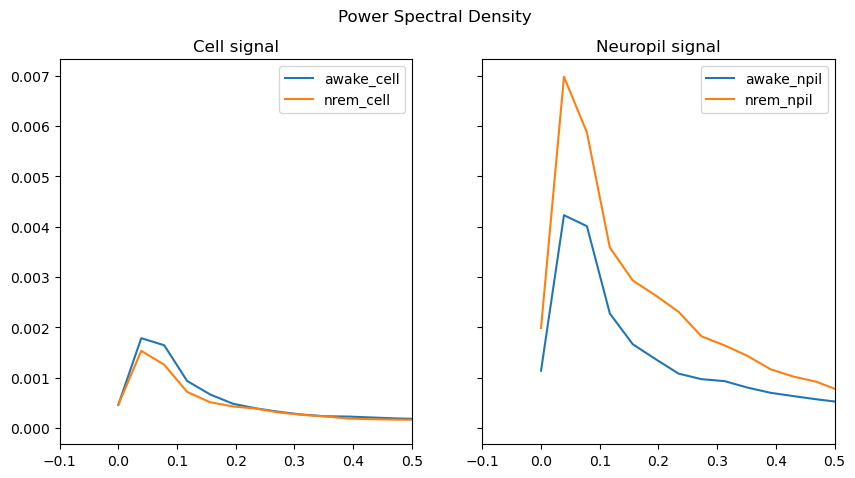

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True, sharex=True)
fig.suptitle("Power Spectral Density")

x = results_df.iloc[0][0]["freq"]
axs[0].plot(x, psd_df.loc["awake_cell"].mean(), label="awake_cell")
axs[0].plot(x, psd_df.loc["nrem_cell"].mean(), label="nrem_cell")
axs[0].legend()
axs[0].title.set_text("Cell signal")

axs[1].plot(x, psd_df.loc["awake_immobile_npil"].mean(), label="awake_npil")
axs[1].plot(x, psd_df.loc["nrem_npil"].mean(), label="nrem_npil")
axs[1].legend()
axs[1].title.set_text("Neuropil signal")

plt.xlim(-0.1, 0.5)
# fig.savefig("psd.png")

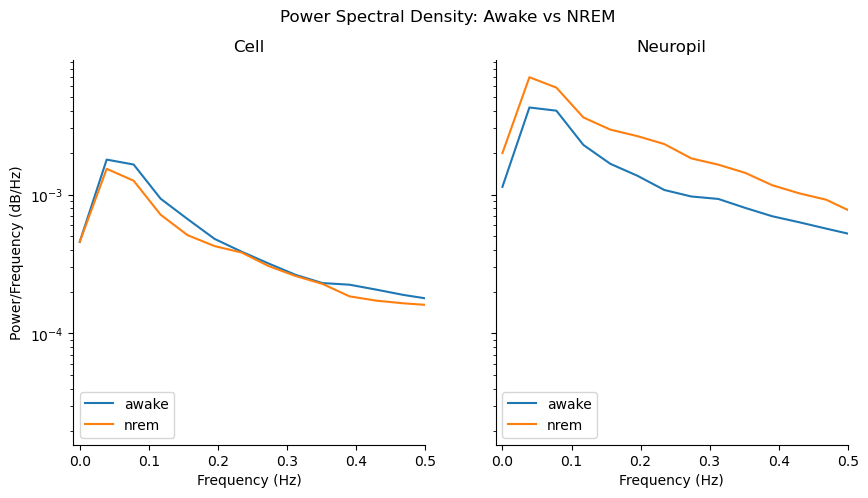

In [29]:
# Create a figure with 2 subplots in 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
fig.suptitle("Power Spectral Density: Awake vs NREM")

# Plot the first semilogy plot in the first subplot
freq = results_df.iloc[0][0]["freq"]
axs[0].semilogy(freq, psd_df.loc["awake_cell"].mean(), label="awake")
axs[0].semilogy(freq, psd_df.loc["nrem_cell"].mean(), label="nrem")
axs[0].legend(loc="lower left")
axs[0].set_title("Cell")
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Power/Frequency (dB/Hz)")
axs[0].set_xlim(-0.01, 0.5)
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)

axs[1].semilogy(freq, psd_df.loc["awake_immobile_npil"].mean(), label="awake")
axs[1].semilogy(freq, psd_df.loc["nrem_npil"].mean(), label="nrem")
axs[1].legend(loc="lower left")
axs[1].set_title("Neuropil")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_xlim(-0.01, 0.5)
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)

fig.savefig("cell npil psd plot.png")

In [30]:
cell_results = {}
npil_results = {}

for sima_folder in sima_folders:
    ##### Data loading and setup
    cell_dict = {}
    npil_dict = {}
    file_name = join(sima_folder, "eeg", "velo_eeg.csv")
    eeg_velo = eegData.load_processed_velocity_eeg(file_name=file_name)
    eeg_velo["mobile_immobile"] = behaviorData.define_immobility(
        eeg_velo["filtered velo"]
    )
    df = eegData.brain_state_filter(
        velo_eeg_df=eeg_velo,
        states=["awake_mobile", "awake_immobile", "NREM", "REM", "other"],
    )
    s2p_folder = join(sima_folder, "suite2p")

    ##### Cell calculation
    s2p_data = Suite2p(s2p_folder=s2p_folder)
    cells = s2p_data.cells()
    npil = s2p_data.npil()
    cell_dfof = s2p_calc_dfof.calculate(signal=cells, npil=npil)

    mean_cellF = cell_dfof.mean(axis=0)

    awake_cell = pd.Series(mean_cellF[df["awake_immobile"]].values)
    awake_cell_freq, awake_cell_psd = freq_calc(awake_cell)
    cell_dict["cell_awake_freq"] = {"freq": awake_cell_freq}
    cell_dict["cell_awake_psd"] = {"psd": awake_cell_psd}
    cell_dict["cell_awake_Ca"] = {"mean_ca": awake_cell}

    nrem_cell = pd.Series(mean_cellF.loc[df["NREM"]].values)
    nrem_cell_freq, nrem_cell_psd = freq_calc(nrem_cell)
    cell_dict["cell_nrem_freq"] = {"freq": nrem_cell_freq}
    cell_dict["cell_nrem_psd"] = {"psd": nrem_cell_psd}
    cell_dict["cell_nrem_Ca"] = {"mean_ca": nrem_cell}

    cell_results[sima_folder] = cell_dict

    ##### Neuropil calculation

    npil_dfof = jia_calc_dfof.calculate(signal=npil)
    mean_npilF = npil_dfof.mean(axis=0)

    awake_immobile_npil = pd.Series(mean_npilF.loc[df["awake_immobile"]].values)
    awake_immobile_npil_freq, awake_immobile_npil_psd = freq_calc(awake_immobile_npil)
    npil_dict["npil_awake_freq"] = ({"freq": awake_immobile_npil_freq},)
    npil_dict["npil_awake_psd"] = {"psd": awake_immobile_npil_psd}
    npil_dict["npil_awake_Ca"] = {"mean_ca": awake_immobile_npil}

    nrem_npil = pd.Series(mean_npilF.loc[df["NREM"], 0])
    nrem_npil_freq, nrem_npil_psd = freq_calc(nrem_npil)
    npil_dict["npil_nrem_freq"] = {"freq": nrem_npil_freq}
    npil_dict["npil_nrem_psd"] = {"psd": nrem_npil_psd}
    npil_results[sima_folder] = npil_dict

ValueError: Unable to coerce to DataFrame, shape must be (476, 24756): given (72, 36000)

In [ ]:
cell_results_df = pd.DataFrame(cell_results)
npil_results_df = pd.DataFrame(npil_results)

In [ ]:
cell_df = cell_results_df.copy()
cell_awake_arrs = []
cell_nrem_arrs = []
for i in range(len(cell_df.columns)):
    cell_awake_arrs.append(cell_df.loc['cell_awake_psd'][i]['psd'])
    cell_nrem_arrs.append(cell_df.loc['cell_nrem_psd'][i]['psd'])
cell_awake_mean_freq = np.mean(cell_awake_arrs, axis=0)
cell_nrem_mean_freq = np.mean(cell_nrem_arrs, axis=0)

npil_df = npil_results_df.copy()
npil_awake_arrs = []
npil_nrem_arrs = []
for i in range(len(npil_df.columns)):
    npil_awake_arrs.append(npil_df.loc['npil_awake_psd'][i]['psd'])
    npil_nrem_arrs.append(npil_df.loc['npil_nrem_psd'][i]['psd'])
npil_awake_mean_freq = np.mean(npil_awake_arrs, axis=0)
npil_nrem_mean_freq = np.mean(npil_nrem_arrs, axis=0)


In [ ]:
npil_df.loc["npil_awake_freq"][0][0]["freq"]

In [ ]:
# Your data and calculations here

# Create the main plot
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
fig.suptitle("Power Spectral Density")
ax[0].plot(
    cell_df.loc["cell_awake_freq"][0]["freq"], cell_awake_mean_freq, label="awake"
)
ax[0].plot(cell_df.loc["cell_nrem_freq"][0]["freq"], cell_nrem_mean_freq, label="nrem")
ax[0].legend(loc="lower right")
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_title("Cell signal")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("Power/Frequency (dB/Hz)")

# Define the bounds of the inset as (x, y, width, height) using figure-relative coordinates
bounds = [0.6, 0.6, 0.35, 0.35]

# Create an inset
axins1 = ax[0].inset_axes(bounds=bounds)
axins1.spines["top"].set_visible(False)
axins1.spines["right"].set_visible(False)

# Plot data in the inset
axins1.plot(
    cell_df.loc["cell_awake_freq"][0]["freq"], cell_awake_mean_freq, label="awake"
)
axins1.plot(cell_df.loc["cell_nrem_freq"][0]["freq"], cell_nrem_mean_freq, label="nrem")

# Adjust the inset's position and axes limits
axins1.set_xlim(-0.01, 0.1)  # Modify these values to specify the desired limits
axins1.set_ylim(0, 7000)  # Modify these values to specify the desired limits

# TODO: hunt down why the indexing is different for the npil data!!!
ax[1].plot(
    npil_df.loc["npil_awake_freq"][0][0]["freq"], npil_awake_mean_freq, label="awake"
)
ax[1].plot(npil_df.loc["npil_nrem_freq"][0]["freq"], npil_nrem_mean_freq, label="nrem")
ax[1].set_title("Npil signal")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].legend(loc="lower right")
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)

# Define the bounds of the inset as (x, y, width, height) using figure-relative coordinates
bounds = [0.6, 0.6, 0.35, 0.35]

# Create an inset
axins2 = ax[1].inset_axes(bounds=bounds)
axins2.spines["top"].set_visible(False)
axins2.spines["right"].set_visible(False)

# Plot data in the inset
axins2.plot(
    npil_df.loc["npil_awake_freq"][0][0]["freq"], npil_awake_mean_freq, label="awake"
)
axins2.plot(npil_df.loc["npil_nrem_freq"][0]["freq"], npil_nrem_mean_freq, label="nrem")

# Adjust the inset's position and axes limits
axins2.set_xlim(-0.01, 0.1)  # Modify these values to specify the desired limits
axins2.set_ylim(0, 3000)  # Modify these values to specify the desired limits

plt.show()